In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 
sys.path.append('../../')

from skyburst.plot import *
from skyburst import utils

# Fig 13: Ablate Waiting Budget Helios

In [2]:
from pathlib import Path
# Replace path with the corresponding log file
log_path = Path('~/logs/ablate_helios_waiting_budget.log').expanduser()
helios_budget_df = utils.load_logs_as_dataframe(log_path)

In [6]:
def set_plotting_setting(ax):
    plt.rcParams.update({'font.size': 15})
    ax.grid(True, which='both')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.tick_params(bottom=False, left=False)
    ax.set_axisbelow(True)
    #ax.set_xlim(left=1.48, right=4)

label_dict = {
    'avg_jct': 'Avg. JCT (hr)',
    'cost_mult': '% Cost Savings\nover No Wait',
    'cost_diff': 'Cost Savings\nover No Wait',
    'cluster_size': 'Cluster Size (# Nodes)',
    'norm_system_utilization': 'System Utilization',
    'system_utilization': 'System Utilization',
    'cluster_utilization': 'Cluster Utilization',
    'total_cloud_cost': 'Cloud Cost',
    'arrival_rate': 'Arrival Rate',
    'norm_cloud_cost': 'Cloud Cost (%)'
}

legend_dict = {
    'constant': 'Constant + OO',
    'linear_runtime': 'Runtime',
    'linear_cost': 'Cost',
    'zero': 'No Wait',
    'linear_runtime_filter_cpu': 'Runtime-Preempt-CPU'
}

def simulator_plotting_fn(df, 
                          x_axis: str,
                          y_axis: list = ['cost_mult', 'avg_jct'],
                          df_filter: dict = {},
                          baseline_filter: dict={'waiting_policy': 'zero',},
                          groupby_values=['waiting_policy', 'waiting_factor'],
                          normalize_x_axis=False):
    if isinstance(y_axis, str):
        y_axis = [y_axis]
    fig, axs = plt.subplots(nrows=1, ncols=len(y_axis), figsize=(5*len(y_axis), 3.5))
    axs = [axs]
    for k,v in df_filter.items():
        df = df[df[k]==v]
    baseline_df = df
    for k,v in baseline_filter.items():
        assert not isinstance(v, list)
        baseline_df = baseline_df[baseline_df[k]==v]
    diff_df = pd.merge(df, baseline_df, left_on='arrival_rate',right_on='arrival_rate')
    if normalize_x_axis:
        if x_axis == 'cluster_size':
            # Hardcoded in Philly trace, precomputed ahead of time
            if df['dataset'].iloc[0] == 'philly':
                total_job_volume = 1155998.77277777
                job_makespan = 2559.3205555555555
            elif df['dataset'].iloc[0] == 'helios':
                total_job_volume = 1853756.1241666232
                job_makespan = 4651.911388888889
            diff_df['norm_system_utilization'] = total_job_volume/(job_makespan*diff_df['cluster_size']*df['gpus_per_node'].iloc[0])
            x_axis = 'norm_system_utilization'
        elif x_axis == 'arrival_rate':
            avg_job_volume_rate = diff_df['arrival_rate'] * np.mean(df['num_gpus'].iloc[0]* df['runtime'].iloc[0])
            print(avg_job_volume_rate)
            diff_df['norm_system_utilization'] = avg_job_volume_rate/(df['cluster_size'].iloc[0]*df['gpus_per_node'].iloc[0])
            x_axis = 'norm_system_utilization'
            print(diff_df['norm_system_utilization'])
    def cost_multiplier(row):
        baseline_cost = row['total_cloud_cost_y']
        cost = row['total_cloud_cost_x']
        if baseline_cost == 0 and cost==0:
            return 0
        elif baseline_cost == 0 and cost>0:
            return 100
        return max(0, 100* (1 - (cost/baseline_cost)))
    
    def cost_difference(row):
        baseline_cost = row['total_cloud_cost_y']
        cost = row['total_cloud_cost_x']
        return baseline_cost - cost
    
    diff_df['norm_cloud_cost'] = diff_df['total_cloud_cost_x']/diff_df['total_cloud_cost_x'].max()
    diff_df['cost_mult'] = diff_df.apply(cost_multiplier, axis=1)
    diff_df['cost_diff'] = diff_df.apply(cost_difference, axis=1)

    groupby_values = [f'{g}_x' if g!='arrival_rate' else g for g in groupby_values]
    mod_y_axis = [f'{y}_x' if y!='cost_mult' and y!='cost_diff' and y!='arrival_rate' and y!='norm_cloud_cost' else y for y in y_axis]
    import itertools
    markers = itertools.cycle(('v', '^','.', 'o', '*',',', '+',)) 
    for idx, (label, grp) in enumerate(diff_df.groupby(groupby_values)):
        marker = next(markers)
        if label[0] == 'constant':
            label = 'Constant-Wait'
            color = 'tab:blue'
            linestyle = (0, (5,1))
            linewidth = 3
        elif label[0] == 'linear_cost' or label[0] == 'linear_cost_filter_cpu':
            label = 'Starburst'
            color = 'tab:orange'
            linestyle = 'solid'
            linewidth = 1.5 
        elif label[0] == 'linear_capacity_filter_cpu':
            label = 'Starburst (No-TE)'
            color = 'tab:green'
            linestyle = (0, (1,1))
            linewidth = 3
        #import pdb; pdb.set_trace()
        for ax_idx, ax in enumerate(axs):   
            grp.plot(x = x_axis + '_x', y = mod_y_axis[ax_idx],ylabel=label_dict[y_axis[ax_idx]], \
                     xlabel=label_dict[x_axis], ax = ax, linestyle = linestyle, linewidth = linewidth, color=color, label = label, legend=None)
        
    for idx, (label, grp) in enumerate(diff_df.groupby(groupby_values)):
        for row in grp.iterrows():
            row = row[1]
            temp=False
            if row['waiting_policy_x'] == 'constant':
                if row['waiting_factor_x'] == 0:
                    marker = 'X'
                    color = 'tab:blue'
                    marker_size = 13
                    temp=True
                elif row['waiting_factor_x'] == 0.2:
                    color = 'tab:green'
                    temp=True
                    marker = 'P'
                    marker_size = 13
                elif row['waiting_factor_x'] == 0.4:
                    color = 'tab:red'
                    temp=True
                    marker = '*'
                    marker_size = 18
                elif row['waiting_factor_x'] == 0.8:
                    color = 'tab:purple'
                    temp=True
                    marker = 's'
                    marker_size = 10
                elif row['waiting_factor_x'] == 1.6:
                    color = 'tab:brown'
                    temp=True
                    marker = 'D'
                    marker_size = 10
                elif row['waiting_factor_x'] == 3.2:
                    color = 'tab:pink'
                    temp=True
                    marker = 'p'
                    marker_size = 13
            elif row['waiting_policy_x'] == 'linear_cost_filter_cpu':
                if row['waiting_factor_x'] == 0.02:
                    color = 'tab:green'
                    temp=True
                    marker = 'P'
                    marker_size = 13
                elif row['waiting_factor_x'] == 0.04:
                    color = 'tab:red'
                    temp=True
                    marker = '*'
                    marker_size = 18
                elif row['waiting_factor_x'] == 0.08:
                    color = 'tab:purple'
                    temp=True
                    marker = 's'
                    marker_size = 10
                elif row['waiting_factor_x'] == 0.16:
                    color = 'tab:brown'
                    temp=True
                    marker = 'D'
                    marker_size = 10
                elif row['waiting_factor_x'] == 0.32:
                    color = 'tab:pink'
                    temp=True
                    marker = 'p'
                    marker_size = 13
            elif row['waiting_policy_x'] == 'linear_capacity_filter_cpu':
                if row['waiting_factor_x'] == 0.08:
                    color = 'tab:green'
                    temp=True
                    marker = 'P'
                    marker_size = 13
                elif row['waiting_factor_x'] == 0.2:
                    color = 'tab:red'
                    temp=True
                    marker = '*'
                    marker_size = 18
                elif row['waiting_factor_x'] == 0.4:
                    color = 'tab:purple'
                    temp=True
                    marker = 's'
                    marker_size = 10
                elif row['waiting_factor_x'] == 0.8:
                    color = 'tab:brown'
                    temp=True
                    marker = 'D'
                    marker_size = 10
                elif row['waiting_factor_x'] == 1.6:
                    color = 'tab:pink'
                    temp=True
                    marker = 'p'
                    marker_size = 13
            
            if temp:
                plt.plot(row['avg_jct_x'], row['norm_cloud_cost'], marker=marker, markersize=marker_size, markeredgecolor=color, markerfacecolor=color)
    
    from matplotlib.lines import Line2D
    plt.legend([Line2D([0], [0], marker='X', color='w', markerfacecolor='tab:blue', \
            markersize=13, markeredgecolor='tab:blue', label='P=0'),
             Line2D([0], [0], marker='P', color='w', markerfacecolor='tab:green', \
             markersize=13, markeredgecolor='tab:green', label='Constant-Wait'),
              Line2D([0], [0], marker='*', color='w', markerfacecolor='tab:red', \
             markersize=18, markeredgecolor='tab:red', label='Starburst'),
             Line2D([0], [0], marker='s', color='w', markerfacecolor='tab:purple', \
             markersize=10, markeredgecolor='tab:purple', label='Constant-Wait + No-SJ'),
              Line2D([0], [0], marker='D', color='w', markerfacecolor='tab:brown', \
             markersize=10, markeredgecolor='tab:brown', label='Constant-Wait + No-SJ'),
             Line2D([0], [0], marker='p', color='w', markerfacecolor='tab:pink', \
             markersize=13, markeredgecolor='tab:pink', label='Constant-Wait + No-SJ')
               ], ['P=0', 'P=10', 'P=25', 'P=50', 'P=100', 'P=200'], ncol=1,loc='lower right', bbox_to_anchor=(1.04, 0.25))

    for ax in axs:
        set_plotting_setting(ax)
    
    lines, labels = ax.get_legend_handles_labels()
    print(labels)
    fig.legend(lines, labels, ncol=len(labels), \
               bbox_to_anchor=(0, 1.02, 1, 0.2), ncols=2, loc='upper center')
    plt.tight_layout()
    plt.savefig('figures/evaluation/helios_budget.pdf', bbox_inches='tight')
    plt.show()

['Constant-Wait', 'Starburst (No-TE)', 'Starburst']


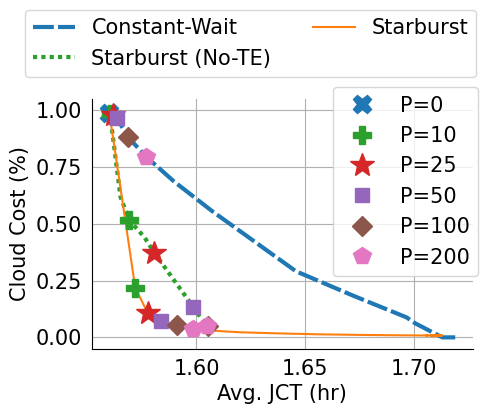

In [7]:
simulator_plotting_fn(helios_budget_df, x_axis='avg_jct',  \
                      y_axis=['norm_cloud_cost'], \
                      baseline_filter={'waiting_policy': 'constant','waiting_factor': 0, },
                      groupby_values=['waiting_policy','loop'],
                      normalize_x_axis=True)

# Fig 13: Ablate Waiting Budget for Philly

In [2]:
from pathlib import Path
# Replace path with the corresponding log file
log_path = Path('~/logs/ablate_philly_waiting_budget.log').expanduser()
philly_budget_df = utils.load_logs_as_dataframe(log_path)

In [5]:
def set_plotting_setting(ax):
    plt.rcParams.update({'font.size': 15})
    ax.grid(True, which='both')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.tick_params(bottom=False, left=False)
    ax.set_axisbelow(True)
    #ax.set_xlim(left=1.48, right=4)

label_dict = {
    'avg_jct': 'Avg. JCT (hr)',
    'cost_mult': '% Cost Savings\nover No Wait',
    'cost_diff': 'Cost Savings\nover No Wait',
    'cluster_size': 'Cluster Size (# Nodes)',
    'norm_system_utilization': 'System Utilization',
    'system_utilization': 'System Utilization',
    'cluster_utilization': 'Cluster Utilization',
    'total_cloud_cost': 'Cloud Cost',
    'arrival_rate': 'Arrival Rate',
    'norm_cloud_cost': 'Cloud Cost (%)'
}

legend_dict = {
    'constant': 'Constant + OO',
    'linear_runtime': 'Runtime',
    'linear_cost': 'Cost',
    'zero': 'No Wait',
    'linear_runtime_filter_cpu': 'Runtime-Preempt-CPU'
}

def simulator_plotting_fn(df, 
                          x_axis: str,
                          y_axis: list = ['cost_mult', 'avg_jct'],
                          df_filter: dict = {},
                          baseline_filter: dict={'waiting_policy': 'zero',},
                          groupby_values=['waiting_policy', 'waiting_factor'],
                          normalize_x_axis=False):
    if isinstance(y_axis, str):
        y_axis = [y_axis]
    fig, axs = plt.subplots(nrows=1, ncols=len(y_axis), figsize=(5*len(y_axis), 3.5))
    axs = [axs]
    for k,v in df_filter.items():
        df = df[df[k]==v]
        
    
       
    baseline_df = df
    for k,v in baseline_filter.items():
        assert not isinstance(v, list)
        baseline_df = baseline_df[baseline_df[k]==v]
        #df = df[df[k]!=v]
    diff_df = pd.merge(df, baseline_df, left_on='arrival_rate',right_on='arrival_rate')
    if normalize_x_axis:
        if x_axis == 'cluster_size':
            # Hardcoded in Philly trace, precomputed ahead of time
            if df['dataset'].iloc[0] == 'philly':
                total_job_volume = 1155998.77277777
                job_makespan = 2559.3205555555555
            elif df['dataset'].iloc[0] == 'helios':
                total_job_volume = 1853756.1241666232
                job_makespan = 4651.911388888889
            diff_df['norm_system_utilization'] = total_job_volume/(job_makespan*diff_df['cluster_size']*df['gpus_per_node'].iloc[0])
            x_axis = 'norm_system_utilization'
        elif x_axis == 'arrival_rate':
            avg_job_volume_rate = diff_df['arrival_rate'] * np.mean(df['num_gpus'].iloc[0]* df['runtime'].iloc[0])
            print(avg_job_volume_rate)
            diff_df['norm_system_utilization'] = avg_job_volume_rate/(df['cluster_size'].iloc[0]*df['gpus_per_node'].iloc[0])
            x_axis = 'norm_system_utilization'
            print(diff_df['norm_system_utilization'])
    def cost_multiplier(row):
        baseline_cost = row['total_cloud_cost_y']
        cost = row['total_cloud_cost_x']
        if baseline_cost == 0 and cost==0:
            return 0
        elif baseline_cost == 0 and cost>0:
            return 100
        return max(0, 100* (1 - (cost/baseline_cost)))
    
    def cost_difference(row):
        baseline_cost = row['total_cloud_cost_y']
        cost = row['total_cloud_cost_x']
        return baseline_cost - cost
    
    diff_df['norm_cloud_cost'] = diff_df['total_cloud_cost_x']/diff_df['total_cloud_cost_x'].max()
    diff_df['cost_mult'] = diff_df.apply(cost_multiplier, axis=1)
    diff_df['cost_diff'] = diff_df.apply(cost_difference, axis=1)

    groupby_values = [f'{g}_x' if g!='arrival_rate' else g for g in groupby_values]
    mod_y_axis = [f'{y}_x' if y!='cost_mult' and y!='cost_diff' and y!='arrival_rate' and y!='norm_cloud_cost' else y for y in y_axis]
    import itertools
    markers = itertools.cycle(('v', '^','.', 'o', '*',',', '+',)) 
    for idx, (label, grp) in enumerate(diff_df.groupby(groupby_values)):
        marker = next(markers)
        if label[0] == 'constant':
            label = 'Constant-Wait'
            color = 'tab:blue'
            linestyle = (0, (5,1))
            linewidth = 3
        elif label[0] == 'linear_cost':
            label = 'Starburst'
            color = 'tab:orange'
            linestyle = 'solid'
            linewidth = 1.5 
        elif label[0] == 'linear_capacity':
            label = 'Starburst (No-TE)'
            color = 'tab:green'
            linestyle = (0, (1,1))
            linewidth = 3
        indices = grp.index
        for ax_idx, ax in enumerate(axs):
            grp.plot(x = x_axis + '_x', y = mod_y_axis[ax_idx],ylabel=label_dict[y_axis[ax_idx]], \
                     xlabel=label_dict[x_axis], ax = ax, color=color, linestyle=linestyle, linewidth = linewidth, label = label, legend=None)
        
    for idx, (label, grp) in enumerate(diff_df.groupby(groupby_values)):
        for row in grp.iterrows():
            row = row[1]
            temp=False
            if row['waiting_policy_x'] == 'constant':
                if row['waiting_factor_x'] == 0:
                    marker = 'X'
                    color = 'tab:blue'
                    marker_size = 13
                    temp=True
                elif row['waiting_factor_x'] == 0.4:
                    color = 'tab:green'
                    temp=True
                    marker = 'P'
                    marker_size = 13
                elif row['waiting_factor_x'] == 1:
                    color = 'tab:red'
                    temp=True
                    marker = '*'
                    marker_size = 18
                elif row['waiting_factor_x'] == 2:
                    color = 'tab:purple'
                    temp=True
                    marker = 's'
                    marker_size = 10
                elif row['waiting_factor_x'] == 4:
                    color = 'tab:brown'
                    temp=True
                    marker = 'D'
                    marker_size = 10
                elif row['waiting_factor_x'] == 8:
                    color = 'tab:pink'
                    temp=True
                    marker = 'p'
                    marker_size = 13
            elif row['waiting_policy_x'] == 'linear_cost':
                if row['waiting_factor_x'] == 0.04:
                    color = 'tab:green'
                    temp=True
                    marker = 'P'
                    marker_size = 13
                elif row['waiting_factor_x'] == 0.08:
                    color = 'tab:red'
                    temp=True
                    marker = '*'
                    marker_size = 18
                elif row['waiting_factor_x'] == 0.16:
                    color = 'tab:purple'
                    temp=True
                    marker = 's'
                    marker_size = 10
                elif row['waiting_factor_x'] == 0.32:
                    color = 'tab:brown'
                    temp=True
                    marker = 'D'
                    marker_size = 10
                elif row['waiting_factor_x'] == 0.64:
                    color = 'tab:pink'
                    temp=True
                    marker = 'p'
                    marker_size = 13
            elif row['waiting_policy_x'] == 'linear_capacity':
                if row['waiting_factor_x'] == 0.32:
                    color = 'tab:green'
                    temp=True
                    marker = 'P'
                    marker_size = 13
                elif row['waiting_factor_x'] == 0.8:
                    color = 'tab:red'
                    temp=True
                    marker = '*'
                    marker_size = 18
                elif row['waiting_factor_x'] == 1.6:
                    color = 'tab:purple'
                    temp=True
                    marker = 's'
                    marker_size = 10
                elif row['waiting_factor_x'] == 3.2:
                    color = 'tab:brown'
                    temp=True
                    marker = 'D'
                    marker_size = 10
                elif row['waiting_factor_x'] == 6.4:
                    color = 'tab:pink'
                    temp=True
                    marker = 'p'
                    marker_size = 13
            
            if temp:
                plt.plot(row['avg_jct_x'], row['norm_cloud_cost'], marker=marker, markersize=marker_size, markeredgecolor=color, markerfacecolor=color)
    
    from matplotlib.lines import Line2D
    plt.legend([Line2D([0], [0], marker='X', color='w', markerfacecolor='tab:blue', \
            markersize=13, markeredgecolor='tab:blue', label='P=0'),
             Line2D([0], [0], marker='P', color='w', markerfacecolor='tab:green', \
             markersize=13, markeredgecolor='tab:green', label='Constant-Wait'),
              Line2D([0], [0], marker='*', color='w', markerfacecolor='tab:red', \
             markersize=18, markeredgecolor='tab:red', label='Starburst'),
             Line2D([0], [0], marker='s', color='w', markerfacecolor='tab:purple', \
             markersize=10, markeredgecolor='tab:purple', label='Constant-Wait + No-SJ'),
              Line2D([0], [0], marker='D', color='w', markerfacecolor='tab:brown', \
             markersize=10, markeredgecolor='tab:brown', label='Constant-Wait + No-SJ'),
             Line2D([0], [0], marker='p', color='w', markerfacecolor='tab:pink', \
             markersize=13, markeredgecolor='tab:pink', label='Constant-Wait + No-SJ')
               ], ['P=0', 'P=10', 'P=25', 'P=50', 'P=100', 'P=200'], ncol=1,loc='lower right', bbox_to_anchor=(1.04, 0.25))



    for ax in axs:
        set_plotting_setting(ax)
    
    lines, labels = ax.get_legend_handles_labels()
    fig.legend(lines, labels, ncol=len(labels), \
               bbox_to_anchor=(0, 1.02, 1, 0.2),loc='upper center', ncols=2)
    plt.tight_layout()
    plt.savefig('figures/evaluation/philly_budget.pdf', bbox_inches='tight')
    plt.show()

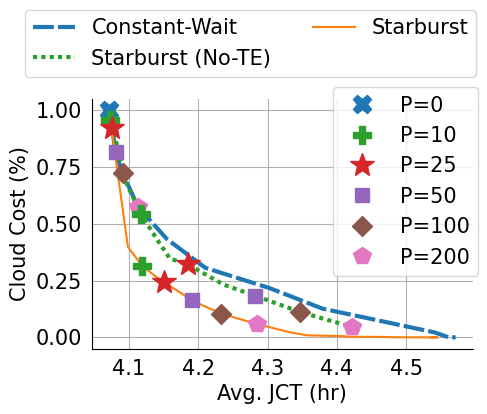

In [6]:
simulator_plotting_fn(philly_budget_df, x_axis='avg_jct',  \
                      y_axis=['norm_cloud_cost'], \
                      baseline_filter={'waiting_policy': 'constant','waiting_factor': 0, },
                      groupby_values=['waiting_policy','loop'],
                      normalize_x_axis=True)